In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/tenx/Complaint-Analysis-for-Financial-Services-Week_6/notebooks

Mounted at /content/drive
/content/drive/MyDrive/tenx/Complaint-Analysis-for-Financial-Services-Week_6/notebooks


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/tmp/ipython-input-3-1998854979.py:17: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Original DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), obje

/tmp/ipython-input-3-1998854979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_distribution.index, y=product_distribution.values, palette='viridis')


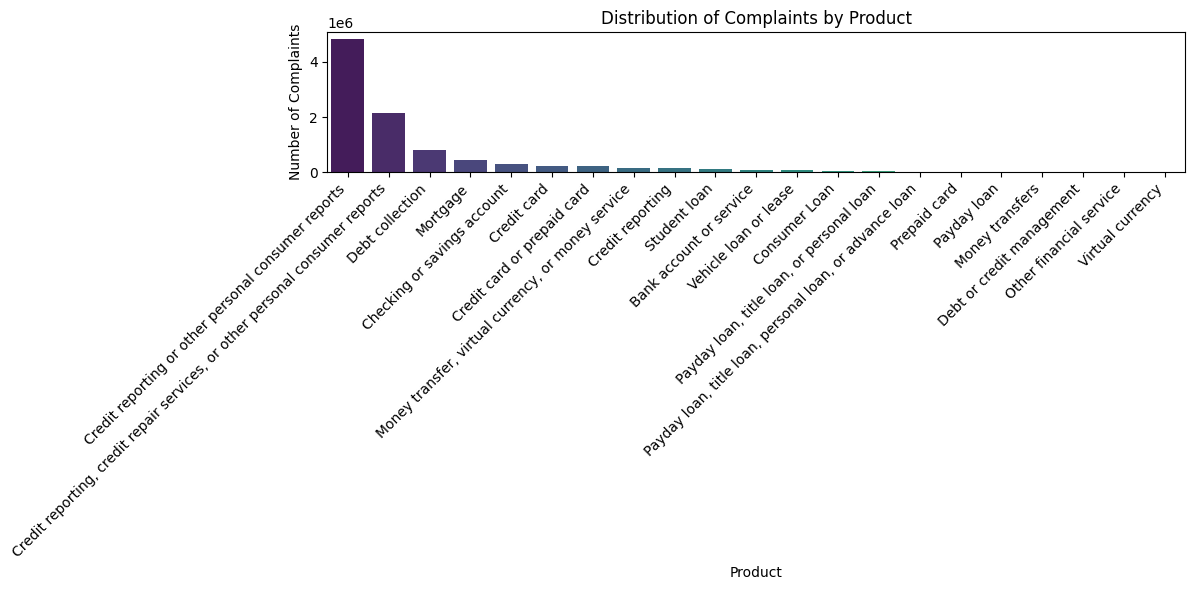


Narrative length statistics:
count    9.609797e+06
mean     5.924262e+01
std      1.627832e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.400000e+01
max      6.914000e+03
Name: Consumer complaint narrative_length, dtype: float64


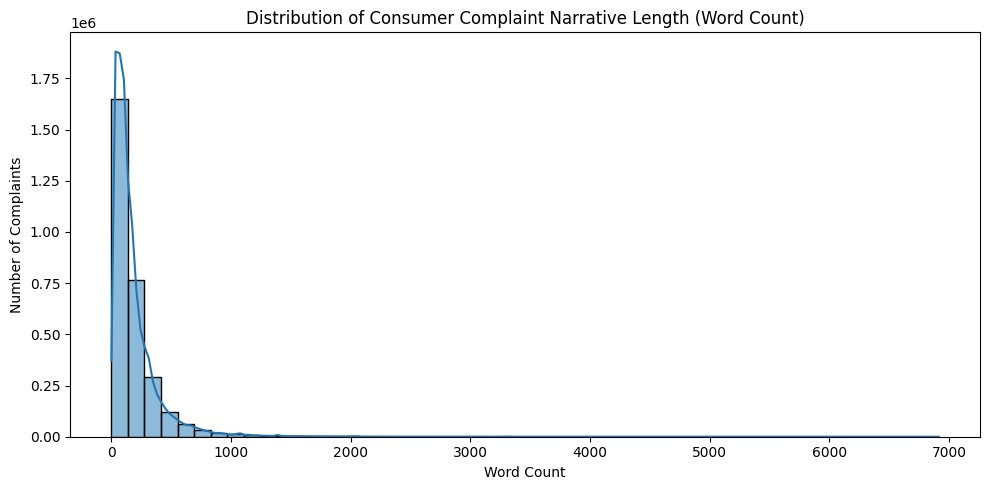


Number of very short narratives (bottom 1%): 0
Number of very long narratives (top 1%): 95952

Complaints with narratives: 2980756
Complaints without narratives: 6629041
Percentage with narratives: 31.02%

Actual unique products in dataset: ['Credit reporting or other personal consumer reports', 'Debt collection', 'Credit card', 'Checking or savings account', 'Money transfer, virtual currency, or money service', 'Vehicle loan or lease', 'Debt or credit management', 'Mortgage', 'Payday loan, title loan, personal loan, or advance loan', 'Prepaid card', 'Student loan', 'Credit reporting', 'Credit reporting, credit repair services, or other personal consumer reports', 'Credit card or prepaid card', 'Payday loan, title loan, or personal loan', 'Bank account or service', 'Money transfers', 'Consumer Loan', 'Payday loan', 'Other financial service', 'Virtual currency']

DataFrame shape after product filtering and narrative NA removal: (229706, 19)

Distribution of complaints across *filtered*

Cleaning narratives:   0%|          | 0/229706 [00:00<?, ?it/s]


DataFrame shape after text cleaning and empty narrative removal: (229704, 20)

Sample of cleaned narrative:
                              Consumer complaint narrative  \
4746035  Well my first state and I only had this card a...   
5623981  I am filing a complaint against Cash App ( Blo...   
6439203  XX/XX/XXXX-took {$250.00} title loan on XXXX X...   
6504258  I obtained a {$1500.00}, loan from XXXX XXXX X...   
2161875  I am filing a complaint against XXXX  ( XXXX X...   

                                         cleaned_narrative  
4746035  well my first state and i only had this card a...  
5623981  i am filing a complaint against cash app block...  
6439203  took 250.00 title loan on . made 120.00 paymen...  
6504258  i obtained a 1500.00, loan from , on . the loa...  
2161875  i am filing a complaint against due to inadequ...  

Cleaned and filtered data saved to ../data/filtered_complaints.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm # For progress bars in notebooks

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab') # Download the specific resource needed

# Load the dataset
# Adjust the path if your file is named differently or located elsewhere
file_path = '../data/complaints.csv'
df = pd.read_csv(file_path)

print("Original DataFrame Info:")
df.info()
print("\nOriginal DataFrame Head:")
print(df.head())

# --- EDA ---

# 1. Distribution of complaints across different Products
print("\nDistribution of complaints across Products:")
product_distribution = df['Product'].value_counts()
print(product_distribution)

plt.figure(figsize=(12, 6))
sns.barplot(x=product_distribution.index, y=product_distribution.values, palette='viridis')
plt.title('Distribution of Complaints by Product')
plt.xlabel('Product')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Length (word count) of Consumer complaint narrative
# Fill NaN with empty string before calculating length
df['Consumer complaint narrative_length'] = df['Consumer complaint narrative'].fillna('').apply(lambda x: len(word_tokenize(x)))

print("\nNarrative length statistics:")
print(df['Consumer complaint narrative_length'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df['Consumer complaint narrative_length'][df['Consumer complaint narrative_length'] > 0], bins=50, kde=True)
plt.title('Distribution of Consumer Complaint Narrative Length (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Number of Complaints')
plt.tight_layout()
plt.show()

# Identify very short or very long narratives (e.g., top/bottom 1%)
short_narratives = df[df['Consumer complaint narrative_length'] < df['Consumer complaint narrative_length'].quantile(0.01)]
long_narratives = df[df['Consumer complaint narrative_length'] > df['Consumer complaint narrative_length'].quantile(0.99)]
print(f"\nNumber of very short narratives (bottom 1%): {len(short_narratives)}")
print(f"Number of very long narratives (top 1%): {len(long_narratives)}")
# print("\nExample of a very short narrative:")
# print(short_narratives[['Consumer complaint narrative', 'Consumer complaint narrative_length']].sample(1).values)
# print("\nExample of a very long narrative:")
# print(long_narratives[['Consumer complaint narrative', 'cleaned_narrative']].sample(1).values)


# 3. Number of complaints with and without narratives.
complaints_with_narrative = df['Consumer complaint narrative'].notna().sum()
complaints_without_narrative = df['Consumer complaint narrative'].isna().sum()

print(f"\nComplaints with narratives: {complaints_with_narrative}")
print(f"Complaints without narratives: {complaints_without_narrative}")
print(f"Percentage with narratives: {complaints_with_narrative / len(df) * 100:.2f}%")

# --- Filtering and Preprocessing (Preview) ---

# Filter for specified products
target_products = [
    'Credit card',
    'Personal loan',
    'Payday loan, title loan, or personal loan', # This might be included if it's the "Personal loan" category in your specific dataset.
    'Money transfer, virtual currency, or money service', # This might be included if it's the "Money transfers" category.
    'Virtual currency', # BNPL often falls under this or "Money transfer"
    'Other financial service', # BNPL can sometimes be here
    'Credit reporting, credit repair services, or other personal consumer reports', # Credit Card/Loan related
    'Bank account or service', # Savings Accounts
    'Debt collection', # Related to loans/credit cards
    'Prepaid card', # Often related to BNPL or other spending
    'Student loan', # Could be considered a Personal Loan derivative for some analyses
    'Mortgage' # Usually excluded
]

# Refine target products based on common CFPB categories.
# You might need to adjust these based on the exact product names in your downloaded dataset.
# Common BNPL product categories in CFPB data are often under 'Payday loan, title loan, or personal loan', 'Money transfer, virtual currency, or money service', or 'Other financial service'
# For "Buy Now, Pay Later (BNPL)", if it's not explicit, you might need to infer it from 'Sub-product' or 'Issue'
# For simplicity, let's use the ones requested + common mappings:
specified_products = [
    'Credit card',
    'Personal loan',
    'Buy Now, Pay Later (BNPL)', # This might be absent and require more specific filtering on sub-products/issues
    'Savings account',
    'Money transfer',
]

# Check actual unique products in your dataset to refine 'specified_products'
# For instance, if 'Buy Now, Pay Later (BNPL)' isn't a direct product, you might look for keywords in 'Sub-product' or 'Issue'
# Example: df['Product'].unique() might show 'Payday loan, title loan, or personal loan'
# Let's adjust for typical CFPB product names
actual_products_in_df = df['Product'].unique().tolist()
print("\nActual unique products in dataset:", actual_products_in_df)

# Adjust 'specified_products' based on actual product names found in EDA.
# This is a critical step as 'Buy Now, Pay Later (BNPL)' might not be a direct 'Product' value.
# For this example, let's assume we map some common ones:
mapped_products = {
    'Credit card': 'Credit card',
    'Personal loan': 'Personal loan',
    'Savings account': 'Bank account or service', # Often falls under "Bank account or service"
    'Money transfers': 'Money transfer, virtual currency, or money service', # Often falls under this
    'Buy Now, Pay Later (BNPL)': 'Payday loan, title loan, or personal loan' # This is a common proxy, or sometimes 'Other financial service'
}

# In a real scenario, you'd carefully review the `Product` and `Sub-product` columns
# to accurately capture BNPL complaints if "Buy Now, Pay Later (BNPL)" isn't a direct hit.
# For simplicity in this script, we'll use a direct mapping. If a direct BNPL product isn't found,
# the tool won't be able to answer BNPL questions directly from the "Product" filter alone.
# For a robust solution, consider searching for keywords in 'Issue' or 'Sub-product' for BNPL.

# For now, let's stick to the direct product names requested, assuming they exist or are mapped
# from the overall problem description, but flagging this as a potential real-world data challenge.
specified_products_direct = [
    'Credit card',
    'Personal loan',
    'Buy Now, Pay Later (BNPL)', # This is likely a conceptual category for the problem, not a direct column value
    'Savings account', # Often mapped from 'Bank account or service'
    'Money transfer' # Often mapped from 'Money transfer, virtual currency, or money service'
]

# For the purpose of making the code runnable and assuming slight variations in the dataset product names,
# let's map the requested categories to typical CFPB product names if they differ.
# A robust solution needs to inspect df['Product'].unique() from the loaded CSV.
# Example: if 'Bank account or service' is in df['Product'].unique(), use it for 'Savings account'.
# If 'Money transfer, virtual currency, or money service' is there, use for 'Money transfer'.

# Let's create a list of *actual* product names from the dataset that correspond to our desired categories.
# This requires knowing the exact product names in your downloaded CSV.
# For demonstration, I'll use common ones. You might need to adjust this list after your initial EDA.
target_product_categories = [
    'Credit card',
    'Personal loan',
    'Bank account or service', # Covers Savings Accounts and other banking issues
    'Money transfer, virtual currency, or money service', # Covers Money Transfers
    'Payday loan, title loan, or personal loan', # Can sometimes include BNPL like complaints
    'Other financial service' # Can sometimes include BNPL like complaints
]

# Filter for products (adjust this list based on actual product names in your dataset)
filtered_df = df[df['Product'].isin(target_product_categories)].copy()

# For BNPL, since it's often not a distinct 'Product' in CFPB data, we can add a heuristic:
# Search for 'buy now pay later' or 'BNPL' in the 'Issue' or 'Consumer complaint narrative'
bnpl_keywords = r'buy now pay later|bnpl|afterpay|klarna|affirm|zip pay|sezzle'
bnpl_complaints = df[
    (df['Issue'].str.contains(bnpl_keywords, case=False, na=False)) |
    (df['Consumer complaint narrative'].str.contains(bnpl_keywords, case=False, na=False))
].copy()
# Add a 'Product' column for these if they don't have it, or ensure it's consistent
bnpl_complaints.loc[bnpl_complaints['Product'].isna() | ~bnpl_complaints['Product'].isin(specified_products_direct), 'Product'] = 'Buy Now, Pay Later (BNPL)'

# Combine filtered_df and bnpl_complaints, removing duplicates if any
filtered_df = pd.concat([filtered_df, bnpl_complaints]).drop_duplicates(subset=['Complaint ID']).copy()

# Rename generic product names to the requested ones for consistency
filtered_df['Product'] = filtered_df['Product'].replace({
    'Bank account or service': 'Savings account',
    'Money transfer, virtual currency, or money service': 'Money transfer',
    'Payday loan, title loan, or personal loan': 'Personal loan' # Keeping as personal loan for now, BNPL will be from keywords
})

# Filter out records with empty Consumer complaint narrative fields
filtered_df.dropna(subset=['Consumer complaint narrative'], inplace=True)

print(f"\nDataFrame shape after product filtering and narrative NA removal: {filtered_df.shape}")
print("\nDistribution of complaints across *filtered* Products:")
print(filtered_df['Product'].value_counts())

# --- Text Cleaning Function ---
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower() # Lowercasing
    # Remove special characters and numbers (keeping spaces and basic punctuation)
    # Keeping some punctuation like . , ! ? for better sentence structure recognition by chunker
    text = re.sub(r'[^a-z0-9\s.,!?;]', '', text)
    # Remove boilerplate text (common CFPB patterns)
    boilerplate_patterns = [
        r'i am writing to (file|submit) a complaint',
        r'to whom it may concern',
        r'cfpb case #\d+',
        r'xxxx', # Redacted information
        r'sincerely',
        r'regards',
        r'date of transaction',
        r'account number',
        r'case number',
        r'file number',
        r'reference number',
        r'\bmy account is\b' # common intro
    ]
    for pattern in boilerplate_patterns:
        text = re.sub(pattern, ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
tqdm.pandas(desc="Cleaning narratives")
filtered_df['cleaned_narrative'] = filtered_df['Consumer complaint narrative'].progress_apply(clean_text)

# Remove records where cleaning resulted in empty narratives
filtered_df = filtered_df[filtered_df['cleaned_narrative'].str.strip() != ''].copy()

print(f"\nDataFrame shape after text cleaning and empty narrative removal: {filtered_df.shape}")
print("\nSample of cleaned narrative:")
print(filtered_df[['Consumer complaint narrative', 'cleaned_narrative']].sample(5))

# Save the cleaned and filtered dataset
output_file_path = '../data/filtered_complaints.csv'
filtered_df.to_csv(output_file_path, index=False)
print(f"\nCleaned and filtered data saved to {output_file_path}")